In [1]:
%load_ext autoreload 
%autoreload 2

import sys
import json
import re
import pandas as pd
import pickle
from numpy.testing import assert_allclose
from pathlib import Path

from dask.distributed import Client
from sklearn import set_config
from macro_utils import load_datastore

# internal
sys.path.append(r"/home/osindi/ami")
sys.path.append(r"/home/osindi/Symawofo")

In [2]:
import os
os.getcwd()

'/home/osindi/ami/notebooks'

In [3]:
# df_master, meta, var_group = load_datastore()

In [4]:
from symawofo import FeatureFrame, DataSplitter, WindowFrame, get_client
client = get_client(0)


## getting the data and running the model

In [5]:
from ami.run.macrobot import MacrobotRunner

asset = 'US_Equity_Fut'
runner = MacrobotRunner(asset)


In [6]:
spec = runner.jobspec
spec.ensemble.n_estimators = 10
spec.ensemble.agg_fn = None

## now you can check the source code used to generate the model (will be inseart into next cell)

In [ ]:
runner.get_source_into_next_cell()

In [21]:
import sys
from typing import Iterable
from tensorflow.keras import regularizers
from tensorflow.keras.layers import (
    Dense,
    # GRU,
    # BatchNormalization,
    Dropout,
    Conv1D,
    Flatten
)
# BatchNormalization._USE_V2_BEHAVIOR = False

from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.layers.recurrent import GRU
sys.path.append(r"C:/SyMAWoFlo/Symawofo")
from symawofo.models.tf import BaseTFRegressor3d
from symawofo.models.base import model


@model(BaseTFRegressor3d)
class GRURegressor:
    def __init__(
            self,
            nodes=15,
            lookback_periods=13,
            activation="selu",
            kernel_initializer='random_uniform',
            regularizer_l1=0.05,
            regularizer_l2=0.0,
            recurrent_dropout=0.0,
            dropout=0.0,
            dense_units: Iterable = tuple(),
            batchnorm=True,
            batchnorm_trainable=True,
            batchnorm_training=False,
            epochs=100,
            batch_size=1000,
            use_bias = False,
            **kwargs
    ):
        super().__init__(**kwargs)

        # for param in inspect.signature(self).parameters.values():
        #     setattr(self, param.name, param.default if param.name != 'dense_layers_list' else [])

        self.nodes = nodes
        self.lookback_periods = lookback_periods
        self.activation = activation
        self.kernel_initializer = kernel_initializer
        self.regularizer_l1 = regularizer_l1
        self.regularizer_l2 = regularizer_l2
        self.recurrent_dropout = recurrent_dropout
        self.dropout = dropout
        self.dense_units = dense_units
        self.batchnorm = batchnorm
        self.batchnorm_training = batchnorm_training
        self.batchnorm_trainable = batchnorm_trainable
        self.batch_size = batch_size
        self.epochs = epochs
        self.use_bias = use_bias

    def _hidden_layers(self, x):
        if self.dropout:
            x = Dropout(self.dropout)(x)

        x = GRU(
            self.nodes,
            activation=self.activation,
            recurrent_dropout=self.recurrent_dropout,
            return_sequences=False,
            kernel_initializer=self.kernel_initializer,
            kernel_regularizer=regularizers.l1_l2(self.regularizer_l1, self.regularizer_l2),
            activity_regularizer=regularizers.l1(0.0),
            use_bias=self.use_bias,
            implementation=1,
            recurrent_activation='hard_sigmoid',
            reset_after=False
        )(x)
    
    
    

        dense_units = self.dense_units or []
        for n in dense_units:
            x = Dense(
                n,
                activation=self.activation,
                name=f'extra_dense{n}',
                kernel_regularizer=regularizers.l1_l2(0.01, 0.01)
            )(x)

        if self.batchnorm:
            x = BatchNormalization()(x)

        x = Dense(
            1,
            activation='linear',
            use_bias=self.use_bias,
            kernel_initializer='random_uniform',
            name='prediction'
        )(x)

        return x

In [17]:
from ami.build.loss import get_loss_fn
from ami.macrobot.jobspec import Jobspec
from symawofo.ensemble import BaggingRegressor
from symawofo.transformers import (Clipper, Difference, Lag, make_column_transformer,
                                   make_pipeline,
                                   StandardScaler, TransformedTargetRegressor)
from symawofo import FeatureFrame, FeatureSeries, DataSplitter, WindowFrame
from symawofo.signals import ThresholdSingSignal
from symawofo.shared.utils import AssetType
from symawofo.pnl import PNL
from macro_utils import DotDict
from ami.build.common import (make_pca_column_transformer, make_pca_diff_column_transformer,
    make_local_data_passthrough)
# from ami.macrobot.models import GRURegressor, CNNRegressor
from ami.build.loss import SampleWeightDecay

import warnings
warnings.filterwarnings("ignore")


#%%

def make_preprocessing(target, prediction_lag):
    target_prepipeline = make_pipeline(
            Difference(),
            Lag(-prediction_lag)
    )
    return target_prepipeline.fit_transform(target)


def make_feature_transform(config: DotDict):
    tr_pca_levels = make_pca_column_transformer(config.PCA)
    tr_pca_diffs = make_pca_diff_column_transformer(config.PCA_diff)
    tr_level_features = [('passthrough', config.pass_through)]
    tr_diffs = [(Difference(1), config.diff)]
    tr_local = make_local_data_passthrough(config)

    ct = tr_pca_levels + tr_pca_diffs + tr_level_features + tr_diffs + tr_local

    return make_pipeline(
            make_column_transformer(*ct, remainder='drop'),
            StandardScaler(),
            Clipper(-config.clip_level, config.clip_level)
    )


def make_model(**kwargs):
    kwargs['loss'] = get_loss_fn(kwargs['loss'])
    sample_weights_fn = SampleWeightDecay(kwargs.get('decay')) if kwargs.get('decay') else None
    if kwargs.pop('type') == 'GruModel':
        return GRURegressor(_sample_weight_fn=sample_weights_fn, **kwargs)
    else:
        return CNNRegressor(_sample_weight_fn=sample_weights_fn, **kwargs)


def make_ensemble_model(jobspec: DotDict):
    model = make_model(**jobspec.model)
    feature_transform = make_feature_transform(jobspec.features_transform)

    if ensemble := dict(jobspec.ensemble):
        if ensemble.pop('type') == 'bagging':
            model = BaggingRegressor(model, **ensemble)

    estimator = make_pipeline(
            feature_transform,
            model
    )
    target_postpipline = make_pipeline(
            StandardScaler(with_mean=jobspec.target_transform.with_mean),
            Clipper(-jobspec.target.clip_level, jobspec.target.clip_level))

    return TransformedTargetRegressor(estimator, target_postpipline)


def make_data_splitter(jobspec: DotDict):
    return  DataSplitter(
            **jobspec.data_splitter,
            drop_remaining=True,
            last_training_window=True
    )


def make_window_frame(jobspec: DotDict, data):
    target = data[jobspec.target.name]
    modeling_features = FeatureFrame(data=data)
    modeling_target = make_preprocessing(target, jobspec.target.prediction_lag)
    splitter = make_data_splitter(jobspec)
    targetRegressor = make_ensemble_model(jobspec)
    wf = WindowFrame(
            features=modeling_features,
            target=modeling_target,
            splitter=splitter,
            estimator=targetRegressor,
            parallel=True
    )
    return wf

def make_signal(jobspec: DotDict, window_frame):
    return ThresholdSingSignal(window_frame, **jobspec.signal)

#%%

def main():
    from ami.run.macrobot import MacrobotRunner

    spec = Jobspec({
    "data_splitter": {
        "expanding": 1,
        "initial_training_size": 375,
        "test_size": 13
    },
    "ensemble": {
        "agg_fn": None,
        "max_samples": 0.9,
        "n_estimators": 1,
        "type": "bagging"
    },
    "features_transform": {
        "PCA": [
            "US_ConsConf"
        ],
        "PCA_diff": [
            "US_Growth",
            "US_ConsConf",
            "US_Inflation",
            "US_Credit_Growth",
            "US_Inflexp",
            "US_FCI",
            "US_Risk",
            "US_WageExp"
        ],
        "clip_level": 8,
        "diff": [
            "GLOB_Equity",
            "US_Breakeven55",
            "US_Bond_10y",
            "US_erp_est",
            "US_AAII_Net",
            "US_CECI",
            "US_eps_upgrade_ratio"
        ],
        "pass_through": [
            "eq_per_flows_USA",
            "eq_ctry2_UnitedStates50_20",
            "US_AAII_Net",
            "US_CFTC_SPX",
            "US_erp_est",
            "US_GSInn",
            "US_Fiscal_Bal",
            "GLOB_CB_Bal",
            "US_CB_Bal",
            "US_2y_v_OIS",
            "US_ForYieldSp",
            "GLOB_EM_HCSp",
            "US_Buybacks_SPX_BBG",
            "US_MA_BBG",
            "GLOB_Equity_Skew",
            "US_Equity_Fut_Chg13",
            "US_Equity_Fut_Chg4",
            "US_CECI",
            "US_eps_upgrade_ratio",
            "ES_Volume_MA",
            "US_Equity_Fut_MASignal",
            "US_Equity_Fut_RSI",
            "US_EqBond_Corr_Ch",
            "US_EqBond_Corr",
            "US_PE",
            "US_Equity_Feature_2"
        ]
    },
    "model": {
        "activation": "selu",
        "batch_size": 1000,
        "batchnorm": True,
        "batchnorm_trainable": True,
        "batchnorm_training": False,
        "decay": 0,
        "dropout": 0.05,
        "epochs": 100,
        "lookback_periods": 13,
        "loss": "mse",
        "nodes": 15,
        "optimizer": "adam",
        "recurrent_dropout": 0.2,
        "regularizer_l1": 0,
        "regularizer_l2": 0,
        "type": "GruModel",
        "use_bias": False
    },
    "signal": {
        "c": 0.1,
        "threshold": None
    },
    "target": {
        "clip_level": 3,
        "name": "US_Equity_Fut",
        "prediction_lag": 1
    },
    "target_transform": {
        "type": "StandardScaler",
        "with_mean": False
    },
    "trade": {
        "t_cost": 0.0001
    }
})
    runner = globals().get('runner', MacrobotRunner(spec.target.name))
    data = runner.get_data()
    wf = make_window_frame(spec, data)
    tradeSignal = ThresholdSingSignal(wf, **spec.signal)
    pnl = PNL(tradeSignal, asset_type=AssetType(log=True, level=False), **spec.trade)
    return pnl


In [18]:
pnl = main()

Monitor progress at http://10.27.2.239:8787/status
Monitor progress at http://10.27.2.239:8787/status


<AxesSubplot:>

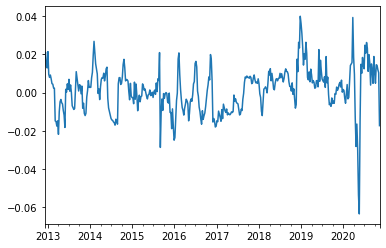

In [19]:
pnl.signal.get_predictions().plot(legend=False)

In [ ]:
a = pnl.get_pnl().diff().mean(axis=1).cumsum()
b = target.diff().reindex_like(pnl.get_pnl()).cumsum()


In [20]:
pnl.signal.wf[0].model.estimators_[0].model_.layers

In [ ]:
from tensorflow.python.keras.layers.recurrent import GRU
a = GRU(10)
a

In [ ]:
pnl.signal.wf[0].model.estimators_[0].model_.optimizer

In [ ]:
pnl.signal.wf[0].model.estimators_[0].model_.layers[3]

In [ ]:
import numpy as np

In [ ]:
from copy import deepcopy
sig2 = deepcopy(pnl.signal)
sig2.predictions = pnl.signal.predictions.mean(axis=1)

In [ ]:
pnl2 = PNL(sig2, asset=target.diff(), asset_type=AssetType(log=True, level=False))

In [ ]:
pnl.signal.get_predictions().plot(legend=False)

In [ ]:
pnl.signal.get_predictions().corr()

In [ ]:
c = pnl.signal.get_predictions()
a.diff().mean()*np.sqrt(52)/a.diff().std()
b.diff().mean()*np.sqrt(52)/b.diff().std()

In [ ]:
from symawofo.signals.pred import ThresholdSignSignal

In [ ]:
pnl.signal.get_predictions().plot()

In [ ]:
data = runner.get_data()
target = data[spec.target.name]

In [ ]:
avg_prediction = pnl.signal.predictions.mean(axis=1)

In [ ]:
avg_prediction.plot()

In [ ]:
from symawofo.signals.pred import ThresholdSignSignal
avg_signal = ThresholdSignSignal(target=target.diff(), predictions=avg_prediction)

In [ ]:
pnl2 = PNL(avg_signal, asset=target.diff(), asset_type=AssetType(log=True, level=False), t_cost=0.0001)
(pnl2.get_pnl()-1).plot()
target.diff().reindex_like(pnl2.get_pnl()).cumsum().plot()

In [ ]:
signal.signals

In [ ]:
np.sign(signal.predictions).mask(signal.predictions.abs()<0, 0).multiply(target.diff(), axis=0).cumsum().plot()

In [ ]:
signal.predictions

In [ ]:
wf.target_lead

In [ ]:
sig = tradeSignal.signals

In [ ]:
np.sign(tradeSignal.predictions).multiply(target.diff(), axis=0).dropna().cumsum().plot()

In [ ]:
target.plot()

In [ ]:
tradeSignal.signals.multiply(target, axis=0).dropna().cumsum().plot()

In [ ]:
t2.signals.multiply(target, axis=0).dropna().cumsum().plot()

In [ ]:
test = t2.wf[-1].model.base_estimator_

In [ ]:
t2.wf.fitted

In [ ]:
t2 = ThresholdSingSignal(tradeSignal.wf, threshold=0.00001)

In [ ]:
t2.signals

In [ ]:
signal = ThresholdSingSignal(wf, threshold=0.001, expanding=spec.data_splitter.expanding, )

In [ ]:
signal.signal

In [ ]:
signal.signal.multiply(target, axis=0).cumsum().dropna().plot()

In [ ]:
average_forecast = signal.predictions

In [ ]:
wf[0].model

## and can change the model generation scripts

In [ ]:
import itertools
def test(x, y):
    print(' we had overwritten the model generation method')
    return 1

runner.overwrite({
    'make_model': make_model
#     'custom_loss': custom_loss,
#     'custom_loss2': custom_loss2
})